# Assignment 3: Edges and Hough transform

### Exercise 1: Image derivatives

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import a3_utils

a) Follow the equations above and derive the equations used to compute first and second derivatives with respect to y: Iy(x,y), Iyy(x,y); as well as the mixed derivative Ixy(x,y)

In [2]:
# Add image

b) Implement a function that computes the derivative of a 1D Gaussian kernel. The formula for the derivative of the Gaussian kernel is: \
`d/dx g(x) = d/dx (1/sqrt(2pi)*sigma) * e^(-x^2/2*sigma^2) = \
-(1/sqrt(2pi) * sigma^3) * xe(-x^2/2*sigma^2)` \

Implement the function `gaussdx(sigma)` that works the same as the function `gauss` from the previous assignment. Don't forget to normalize the kernel. Be careful as the derivative is an odd function, so a simple sum will not do. Instead normalize the kernel by dividing hte values such that the sum of absoulte values is 1. Effectively you have to divide each value by sum(abs(gx(x)))

In [83]:
def normalize(xs):
    res = [abs(x) for x in xs]
    return xs / np.sum(res)
    

def gaussdx(sigma):
    return np.array(normalize([(-1/(np.sqrt(2 * np.pi) * sigma**3)) * x * np.exp(-x**2 / (2 * sigma**2)) for x in np.arange(-np.ceil(3*sigma), np.ceil(3*sigma)+1, 1)]))

1.0


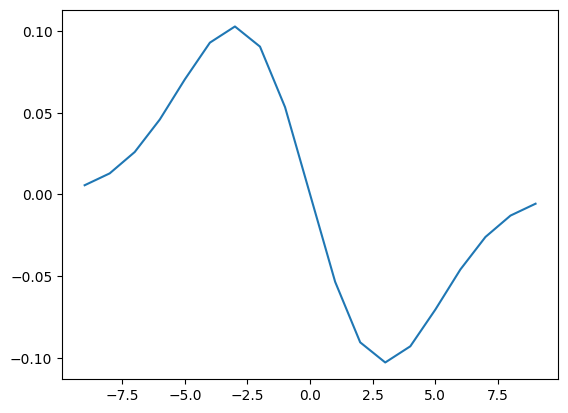

In [87]:
# Test
print(sum(np.abs(gaussdx(3))))
plt.plot([x for x in np.arange(-np.ceil(3*3), np.ceil(3*3)+1, 1)], gaussdx(3))

c) The properties of the filter can be analyzed by usin an `impulse response function`. This is performed as a convolution of the filter with a Dirac delta function. The discrete version of the Dirac function is constructed as a finite image that has all elements set to 0 except the central element, which is set to a high value. \
Generate a 1D Gaussian kernel G and a Gaussian derivative kernel D. What happens if you apply the following operations to the impulse image?  
*    Impulse * G * G.T 
*    Impulse * G * D.T 
*    Impulse * D * G.T 
*    Impulse * G.T * D 
*    Impulse * D.T * G 

Is the order of operations important? Display the images of the impulse responses for different combinations of operations.

In [85]:
def gaussian_kernel(sigma):
    return np.array([1 / (np.sqrt(2*np.pi) * sigma) * np.exp((-np.square(x)) / (2 * np.square(sigma))) for x in np.arange(-np.ceil(3*sigma), np.ceil(3*sigma)+1, 1)])

Text(0.5, 1.0, 'D.T * G')

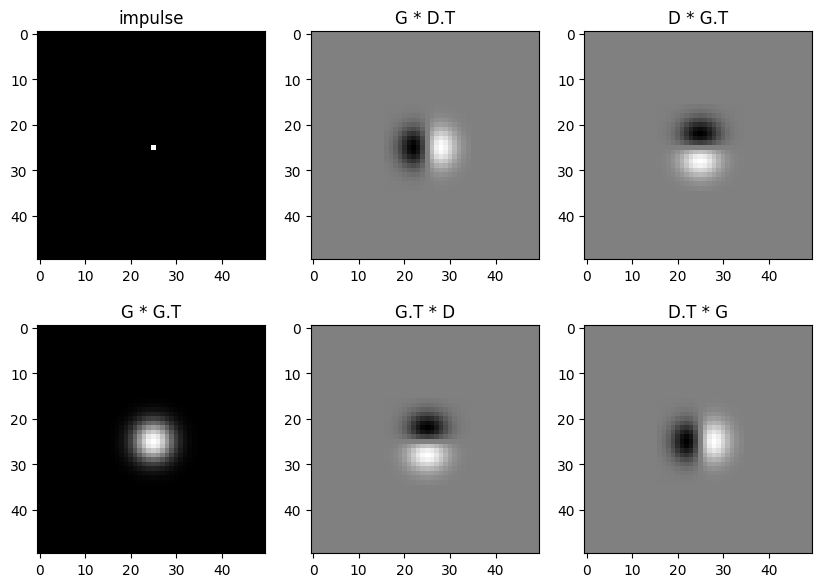

In [98]:
sigma = 3
G = gaussian_kernel(sigma)
GT = np.reshape(G, (1, -1))
D = gaussdx(sigma)
DT = np.reshape(D, (1, -1))

#plt.plot([x for x in np.arange(-np.ceil(3*3), np.ceil(3*3)+1, 1)], D)

impulse = np.zeros((50,50))
impulse[25,25] = 1

# a
ggt = cv2.filter2D(cv2.filter2D(impulse, -1, G), -1, GT)

#b
gdt = cv2.filter2D(cv2.filter2D(impulse, -1, G), -1, DT)

#c
dgt = cv2.filter2D(cv2.filter2D(impulse, -1, D), -1, GT)

#d
gtd = cv2.filter2D(cv2.filter2D(impulse, -1, GT), -1, D)

#e
dtg = cv2.filter2D(cv2.filter2D(impulse, -1, DT), -1, G)

fig, ax = plt.subplots(2,3,figsize=(10,7))

ax[0][0].imshow(impulse, cmap="gray")
ax[0][1].imshow(gdt, cmap="gray")
ax[0][2].imshow(dgt, cmap="gray")
ax[1][0].imshow(ggt, cmap="gray")
ax[1][1].imshow(gtd, cmap="gray")
ax[1][2].imshow(dtg, cmap="gray")
ax[0][0].set_title("impulse")
ax[0][1].set_title("G * D.T")
ax[0][2].set_title("D * G.T")
ax[1][0].set_title("G * G.T")
ax[1][1].set_title("G.T * D")
ax[1][2].set_title("D.T * G")


No, the order of operations doesn't matter as convolution is commutative.

d) Implement a function that uses functions `gauss` and `gaussdx` to compute both
partial derivatives of a given image with respect to x and with respect to y. \
Similarly, implement a function that returns partial second order derivatives of a
given image.
Additionally, implement the function `gradient_magnitude` that accepts a grayscale
image I and returns both derivative magnitudes and derivative angles. Magnitude is calculated as
`m(x,y) = sqrt(Ix(x,y)^2 + Iy(x,y)^2)`
 and angles are calculated as
`φ(x,y) = arctan(Iy(x, y)/Ix(x, y))`
Hint: Use function `np.arctan2` to avoid division by zero for calculating the arctangent function.
Use all the implemented functions on the same image and display the results in the
same window.

In [121]:
def derive_1(img, sigma):
    gx = gaussian_kernel(sigma)
    gy = np.reshape(gx, (1, -1))
    
    d_gx = gaussdx(sigma)
    d_gy = np.reshape(d_gx, (1, -1))
    
    dx_img = cv2.filter2D(cv2.filter2D(img, -1, gy), -1, d_gx)
    dy_img = cv2.filter2D(cv2.filter2D(img, -1, gx), -1, d_gy)
    
    return dx_img, dy_img

def derive_2(img, sigma):
    gx = gaussian_kernel(sigma)
    gy = np.reshape(gx, (1, -1))
    
    d_gx = gaussdx(sigma)
    d_gy = np.reshape(d_gx, (1, -1))
    
    dx_img, dy_img = derive_1(img, sigma)
    
    dxx_img = cv2.filter2D(cv2.filter2D(dx_img, -1, gy), -1, d_gx)
    dxy_img = cv2.filter2D(cv2.filter2D(dx_img, -1, gx), -1, d_gy)
    dyy_img = cv2.filter2D(cv2.filter2D(dy_img, -1, gy), -1, d_gy)
    
    return dxx_img, dxy_img, dyy_img

def gradient_magnitude(img):
    return
    

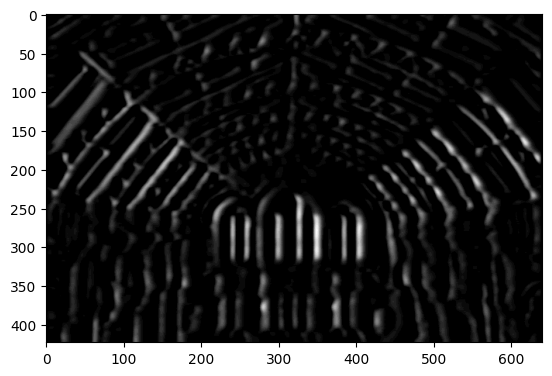

In [125]:
img = cv2.imread("images/museum.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Ix, Iy = derive_1(img, 10)
Ixx, Ixy, Iyy = derive_2(img, sigma)

fig, ax = plt.subplots(2,4,figsize=(9,7))

ax[0][0].imshow(img, cmap="gray")
ax[0][1].imshow(Ix, cmap="gray")
ax[0][2].imshow(Iy, cmap="gray")
#ax[0][3].imshow(Imag, cmap="gray")
ax[1][0].

plt.imshow(Iyy, cmap="gray")